Important Note: a lot of this code is directly copied or heavily based on the [pyPESTO source code](https://github.com/ICB-DCM/pyPESTO/tree/main/pypesto/objective/roadrunner)

In [1]:
import numpy as np
import pandas as pd
import tempfile
import petab
import copy
import pypesto.objective
import pypesto.optimize as optimize
import pypesto.objective.roadrunner as pypesto_rr
import pypesto.sample as sample
import pypesto.visualize as visualize
import pypesto.profile as profile
import pypesto.store as store
from IPython.display import Markdown, display
from pprint import pprint

np.random.seed(123)

model_name = "Michaelis_Menten"

In [2]:
petab_yaml = f"./{model_name}/{model_name}.yaml"

petab_problem = petab.Problem.from_yaml(petab_yaml)
importer = pypesto_rr.PetabImporterRR(petab_problem)
problem = importer.create_problem()


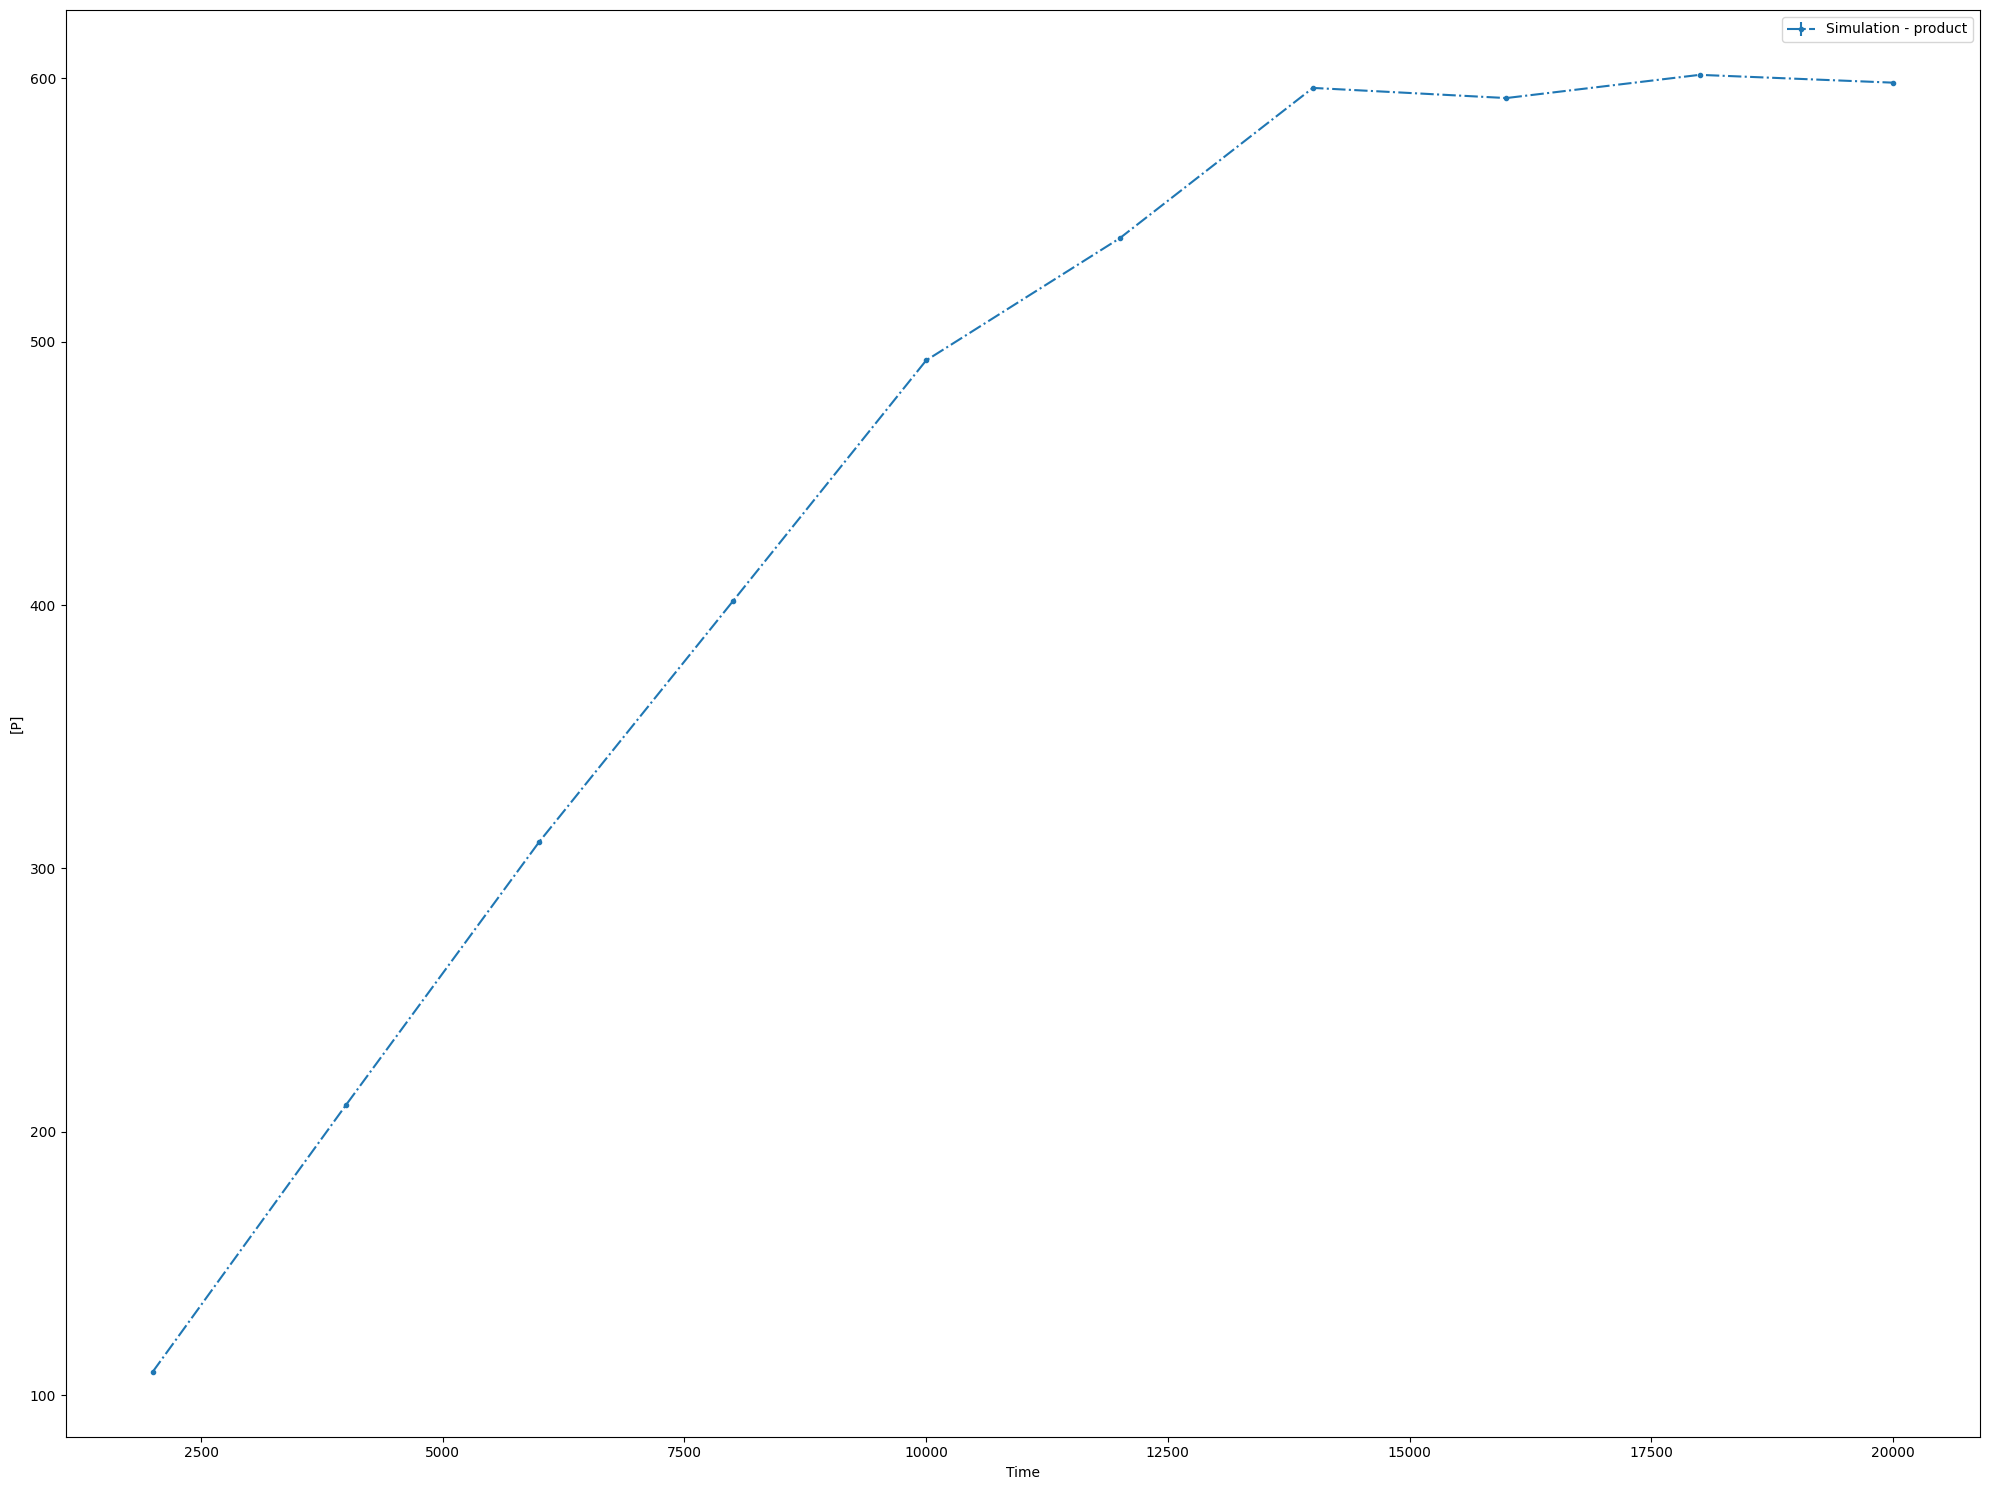

In [3]:
petab.visualize.plot_problem(petab_problem);

     time,      [S1],     [S2],       [S3],    [S4]
 [[     0,       600,        6,          0,       0],
  [  2500,   461.256,  0.73873,    5.26127, 133.483],
  [  5000,   332.695, 0.977601,     5.0224, 262.283],
  [ 10000,   107.554,  2.25358,    3.74642,   488.7],
  [ 15000,   5.97573,  5.49014,   0.509857, 593.514],
  [ 17500,  0.757098,  5.93015,  0.0698452, 599.173],
  [ 20000, 0.0903424,  5.99158, 0.00842199, 599.901]]



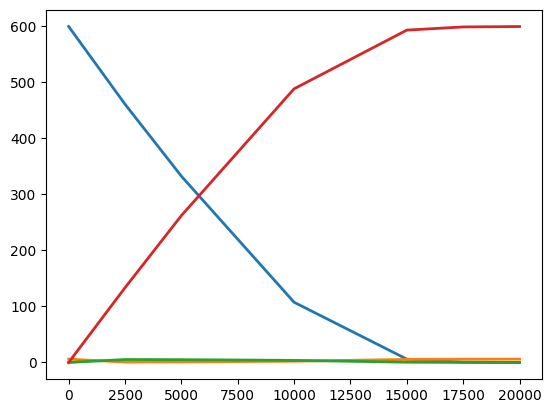

In [4]:
# direct simulation of the model using roadrunner
sim_res = problem.objective.roadrunner_instance.simulate(
    times=[0, 2500, 5000, 10000, 15000, 17500, 20000]
)
pprint(sim_res)
problem.objective.roadrunner_instance.plot();

In [5]:
ret = problem.objective(
    petab_problem.get_x_nominal(fixed=False,scaled=True),
    mode="mode_fun",
    return_dict=True,
)
pprint(ret)

{'fval': 177.58442025403264,
 'llh': -177.58442025403264,
 'simulation_results': {'simCondition':      time, product
 [[     0,       0],
  [  2000, 107.087],
  [  4000, 211.486],
  [  6000,  311.84],
  [  8000, 405.779],
  [ 10000,   488.7],
  [ 12000,  551.96],
  [ 14000, 586.184],
  [ 16000, 597.104],
  [ 18000, 599.458],
  [ 20000, 599.901]]
}}


In [6]:
import scipy
print(scipy.optimize.show_options("minimize", method="Nelder-Mead"))

Minimization of scalar function of one or more variables using the
Nelder-Mead algorithm.

Options
-------
disp : bool
    Set to True to print convergence messages.
maxiter, maxfev : int
    Maximum allowed number of iterations and function evaluations.
    Will default to ``N*200``, where ``N`` is the number of
    variables, if neither `maxiter` or `maxfev` is set. If both
    `maxiter` and `maxfev` are set, minimization will stop at the
    first reached.
return_all : bool, optional
    Set to True to return a list of the best solution at each of the
    iterations.
initial_simplex : array_like of shape (N + 1, N)
    Initial simplex. If given, overrides `x0`.
    ``initial_simplex[j,:]`` should contain the coordinates of
    the jth vertex of the ``N+1`` vertices in the simplex, where
    ``N`` is the dimension.
xatol : float, optional
    Absolute error in xopt between iterations that is acceptable for
    convergence.
fatol : number, optional
    Absolute error in func(xopt) bet

In [7]:
solver_options = pypesto_rr.SolverOptions(
    relative_tolerance = 5e-10,
    absolute_tolerance = 1e-10,
)
engine = pypesto.engine.MultiProcessEngine()
problem.objective.solver_options = solver_options

Engine will use up to 24 processes (= CPU count).


optimizer = optimize.ScipyOptimizer(method="Nelder-Mead", options={"maxiter":10000})
result = optimize.minimize(
    problem=problem,
    optimizer=optimizer,
    n_starts=100,  # usually a value >= 100 should be used
    engine=engine
)
display(Markdown(result.summary()))

In [8]:
#visualize.waterfall(result);

In [9]:
#visualize.optimization_scatter(result)

In [22]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=4
)

Initializing betas with "near-exponential decay".


In [23]:
for key in sampler.__dict__.keys():
    print(f"{key}:\t{sampler.__dict__[key]}")

options:	{'max_temp': 50000.0, 'exponent': 4, 'temper_log_posterior': False, 'show_progress': None, 'beta_init': 'exponential_decay', 'alpha': 0.3, 'eta': 100, 'nu': 1000.0}
betas0:	[1.00000000e+00 9.80502681e-04 8.87685203e-05 2.00000000e-05]
betas:	None
temper_lpost:	False
samplers:	[<pypesto.sample.adaptive_metropolis.AdaptiveMetropolisSampler object at 0x75e6afd7f4a0>, <pypesto.sample.adaptive_metropolis.AdaptiveMetropolisSampler object at 0x75e6c4a2f9e0>, <pypesto.sample.adaptive_metropolis.AdaptiveMetropolisSampler object at 0x75e6ac980980>, <pypesto.sample.adaptive_metropolis.AdaptiveMetropolisSampler object at 0x75e6ac9821e0>]


In [24]:
print(sampler.default_options())

{'max_temp': 50000.0, 'exponent': 4, 'temper_log_posterior': False, 'show_progress': None, 'beta_init': 'exponential_decay', 'alpha': 0.3, 'eta': 100, 'nu': 1000.0}


In [25]:
%%time
result = sample.sample(
    problem, n_samples=100000, sampler=sampler, x0=np.array([-1,1,0]), filename=None
)

100%|██████████| 100000/100000 [18:10<00:00, 91.71it/s]
Elapsed time: 1095.426434487


CPU times: user 18min 11s, sys: 4.6 s, total: 18min 15s
Wall time: 18min 10s


In [27]:
store.write_result(
    result=result,
    filename="result.hdf5",
    problem=True,
    sample=True,
)

In [28]:
sample.geweke_test(result)

Geweke burn-in index: 15000


15000

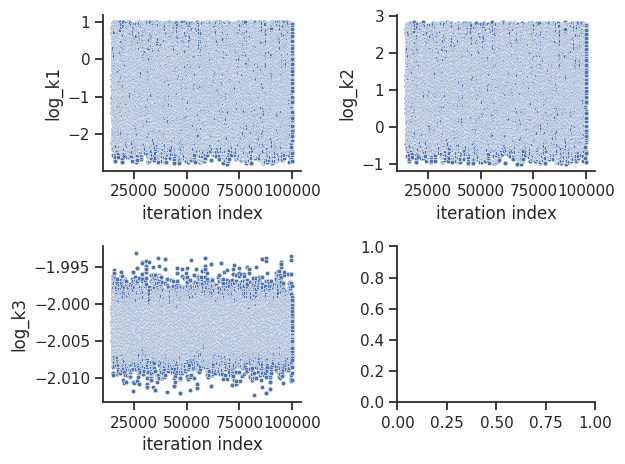

In [29]:
ax = visualize.sampling_parameter_traces(result, use_problem_bounds=False)

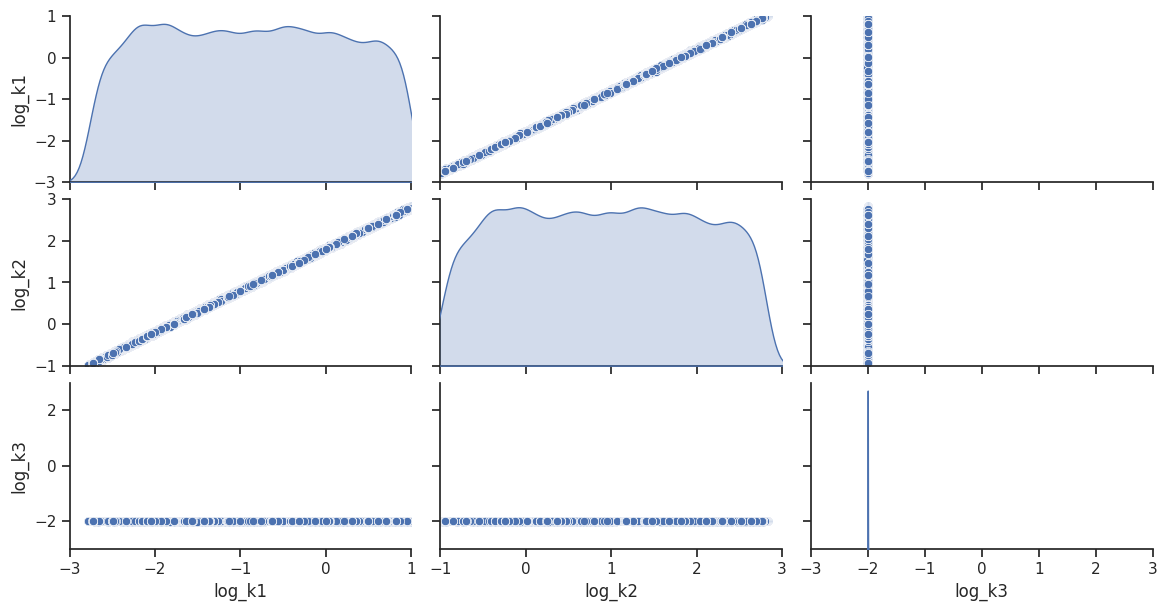

In [30]:
ax = visualize.sampling_scatter(result, size=[13, 6])

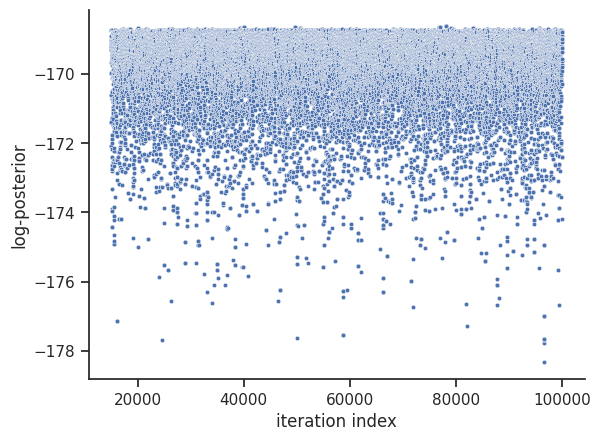

In [31]:
ax = visualize.sampling_fval_traces(result)

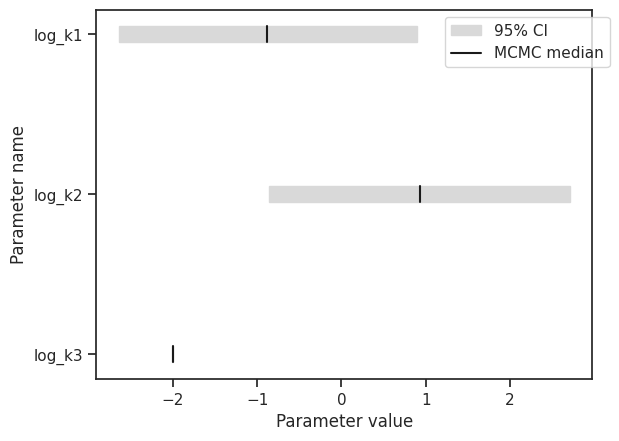

In [32]:
ax = visualize.sampling_parameter_cis(result)

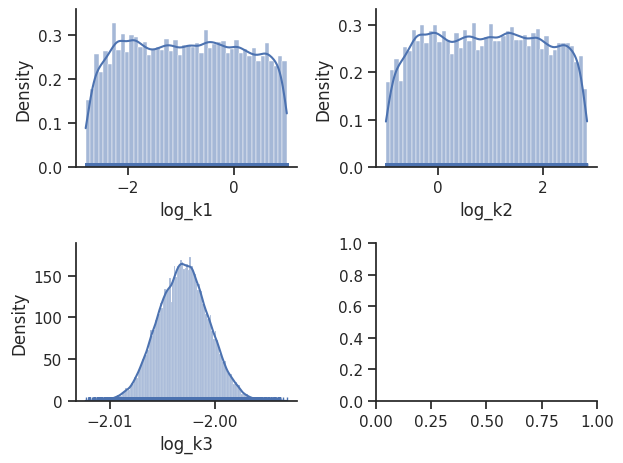

In [33]:
ax = visualize.sampling_1d_marginals(result)